## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('AnalyzeABTestResults/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df_treatment_newpage_mismatch = (((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False)
df_treatment_newpage_mismatch.sum()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum().any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df[df_treatment_newpage_mismatch].index)

In [9]:
df2.shape[0]

290585

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'])]['user_id'].value_counts()

773192    1
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(['user_id'], inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [19]:
observed_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
observed_diff

-0.0015782389853555567


We have cleaned up the dataframe such that for treatment group, the landing page will always be a new page. We see that the probability of getting a new page is roughly 50%, and the conversion rate for the new page and the old page is roughly the same, with the new_page actually having a slightly lower probability of conversion (11.88%) as opposed to the older page (12.04%). Hence, there isn't sufficient evidence to say that the new treatment leads to more conversions, and by simply comparing the means it looks like the old page is as good if not slightly better than the new page judging by the conversion rates.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null Hypothesis: p_old >= p_new, i.e converted rates for the old page is better than or on par with new page conversion rates

Alternative Hypothesis: p_old < p_new, i.e. new page conversion ratios are better than old page

Rearraging the equations above, we can state the two hypotheses as follows:

Null Hypothesis: p_old - p_new >= 0
Alternative Hypothesis: p_old - p_new < 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = (df2['landing_page'] == 'new_page').sum()
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = (df2['landing_page'] == 'old_page').sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# We perform sampling with replacement of n_new transactions from the original dataset
new_page_converted = df.sample(n_new, replace=True)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# We perform sampling with replacement of n_old transactions from the original dataset.
# Since we are sampling under null, the way we sample for new and old page conversion ratios is identical except for difference in number of samples which matches their numbers in the original distribution.
old_page_converted = df.sample(n_old, replace=True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted['converted'].mean() - old_page_converted['converted'].mean()

-0.0007386324785860071

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
new_page_converted_10000 = np.random.binomial(n_new, p_new,  10000)/n_new
old_page_converted_10000 = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_page_converted_10000 - old_page_converted_10000

In [28]:
# Python suboptimal method
# p_diffs = []
# for _ in range(10000):
#     new_page_converted_means = df.sample(n_new, replace=True)['converted'].mean()
#     old_page_converted_means = df.sample(n_old, replace=True)['converted'].mean()
#     p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

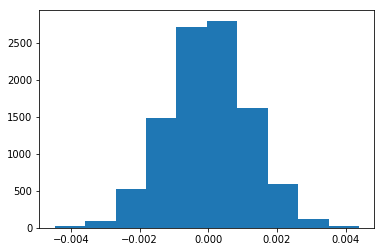

In [30]:
plt.hist(p_diffs);

In [31]:
np.mean(p_diffs)

-8.497718876068067e-07

We see that the mean of the sampling distribution for the difference is conversion rate is very close to zero. Under our null hypothesis, this difference would be zero. Given the ratios we observed for conversion in each group earlier and our guess that null hypothesis probably holds true, this histogram is along expected lines. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

Let's plot a line indicating where our observed difference in conversion rate for new vs old on the full data, lies.

In [33]:
# Python suboptimal method
# std_p_diff_10000 = np.std(p_diffs)
# null_vals = np.random.normal(0, std_p_diff_10000, 10000)
# plt.hist(null_vals)

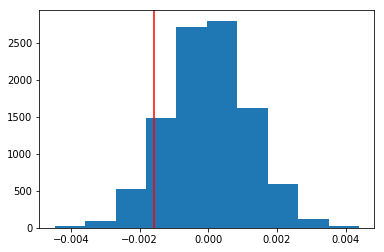

In [34]:
plt.hist(p_diffs)
plt.axvline(x=observed_diff, color='red');

The probabilit of observing this difference or one more extreme in favor of alternate hypothesis, is basically the area under the curve from the red line to the right of the distribution (since our alternate hypothesis states that new mean will be greater). This area is clearly large and greater than 0.5. Let's compute the exact value below.

In [36]:
(p_diffs > observed_diff).mean()

0.9087

We fail to reject the null hypothesis. This is based on the data which shows a very high probabilty for our observed statistic to occur, assuming null hypothesis is true. There doesn't appear any evidence to suggest that the new page conversion ratios are higher than old page. 

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value we computed in j is the p-value. In the context of difference between the two pages, the p-value is the probability of observing the difference between conversion ratios of new page and old page to be -0.0015782389853555567 under the assumption of null-hypothesis being true (old page conversion ratios are as good if not better than the old page). Since this p-value is very high, we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new =  df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [39]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Yes, the p-values and the findings agree with the values computed in j and k. The null and the alternative hypothesis for the z-test here is same as the hypothesis in j and k. The null hypothesis states that the proportion of conversion for new page and old page are identical or old is greater and the alternative hypothesis states that new page conversion proportions are greater. From our proportions, we know that the convert_old ratio is slightly higher than convert_new ratio. So, even if conversion ratio differences were significant, it would only suggest that the old page was better. Since our z value is lower than the 95% CI z-value of 1.959963984540054 we know that the difference is actually not significant even in favor of older page. So, there is no way to pick new page as being significantly better than old page. These conclusions are in agreement with the finding in j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since our response variable is categorical, we need perform logistic regression in this case.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
df2['intercept'] = 1

In [41]:
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

In [42]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [43]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [44]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [45]:
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        06:55:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value for regression associated with the null hypothesis of ab_page slope being zero, is 0.190. This means that we have a non-zero significant probability that causes us to fail to reject the null hypothesis. So our conclusions match up with the part II conclusions. In Part II since our null-hypothesis was that the new page conversion ratio is not significantly higher than the old page conversion ratio, the p-values there were different from the p-value of regression. In part II, the null hypothesis was built around the average conversion ratio difference from the sampling distribution whereas over here the null hypothesis is built around a non-zero value for the slope of the line fitted through conversion_ratio vs ab_page plot using ordinary least squares.  In both cases, we fail to reject the null-hypothesis which points in the direction of ab_page not being a factor in predicting conversion rate.

The other thing we see that ab_page has a negative coefficient which suggests that for ab_page = 1, ie for new page, there is actual a drop in conversion ratio by a factor equal to inverse of the exponent of the coefficient.

In [47]:
#Factor by which conversion ratio drops when going to new page.
1/np.exp(-0.015)

1.015113064615719

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Since there doesn't appear to be a linear relationship between ab_page and conversion_ratio, we might want to look at other factors that could capture the relationship. However, if the newly introduced factors aren't entirely indepdent of ab_page, this could lead to the coefficients being flipped in the regression summary, and the r squared value exceeding 1. The interaction between the factors would also have to be captured in that case.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
countries_df = pd.read_csv('AnalyzeABTestResults/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [49]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [50]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [51]:
### Create the necessary dummy variables

In [52]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [53]:
# We use US as the baseline

In [54]:
log_mod_2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])

In [55]:
results_2 = log_mod_2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [56]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 23 Jul 2018   Pseudo R-squ.:               2.323e-05
Time:                        06:55:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [57]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

Looking at the coefficients it would appear as if CA has a factor of 1.04 lower conversion rate than US, and UK has a factor of 1.0099 higher conversion rate than US. These values are not significant in themselves, and this is further confirmed by the high p-value which causes to fail to reject the null hypothesis that the slope between the factors and conversion ratio is not significant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [58]:
df_new['page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['page_UK'] = df_new['ab_page'] * df_new['UK']

In [59]:
### Fit Your Linear Model And Obtain the Results

In [60]:
log_mod_3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'page_CA', 'page_UK']])

In [61]:
results_3 = log_mod_3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [62]:
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 23 Jul 2018   Pseudo R-squ.:               3.482e-05
Time:                        06:55:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

We see that the interaction between page and countries is not significant either, judging by the p-values which cause to fail to reject the regression null hypothesis. Hence, our conclusion for the overall results for our AB testing is that the e-commerce website should stick with the old page. This conclusion has been supported by three approaches - probabilistic approach looking at the conditional probability of conversion given new or old, statistical approach based on bootstrap sampling which failed to reject the null hypothesis that the old page is as good or better than new page interms of conversion ratio, and the regression based approach which failed to identify any significant rate of change in conversion acrosss different groups and failed to identify interactions between groups and countries in terms of conversion ratios.

